In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
# import functions from the modsim.py module
from modsim import *
import scipy.signal as sigw

# Question: How does the transient response of a full-wave bridge rectifier change given different waveforms? 

### By Shashank Swaminathan and Michael Remley

The purpose of a full-wave bridge rectifier is to take an AC input and turn it into a DC output.
A full-wave bridge rectifier consists of two parts: the full-wave rectifier, made by four diodes, and an RLC circuit to stabilize the output. Refer to Figure 1 for a diagram of the circuit we are simulating.
This rectifier design is one of many, but the task it accomplishes is all around us in devices wall adapters, chargers, and appliances.

Its prevalence in numerous appliances and technologies today implies its importance to both users and designers. For those designing circuits based around full wave rectifiers, the different stages of the recitifier's output, the transient and steady state stages, are the main points of interest. The transient stage, or the stage in which the voltage response of the rectifier is still stabilizing, is of particular interest, because it indicates both the stabiility and robustness of the rectifier design. It also points out at what time the transient response steadies to the equilibrium voltage output. Investigations into this usually require physical construction of rectifier prototypes, which can become costly over time, as well as demanding in manual effort.

In comparison, utilizing a model to understand these rectifier design responses is far more ideal. Doing so would allow quick sweeping of different design (bridge design) and control (input waveforms to the rectifier) parameters. We therefore approach the question by constructing a model that allows sweeping of different waveforms through the rectifier. The model will output the rectifier response, which we can use to understand the transient responses per different waveform.

The model is constructed via two different approaches, abstraction and analytical breakdown, and can be simulated using either. Validation of the model's results is done by comparing results against that of a commercial-grade modeling tool.

# Model

## System Setup

To initialize our system, we need to construct two key components: the input wave generator, and the actual rectifier system.

The input wave generator is essentially a function that outputs the input voltage over time; because we are interested in dealing with multiple types of input functions, we created a convenience wrapper function that returns the desired input function. Essentially, it acts as a input wave *function* generator; it takes inputs of wave type, frequency, RMS voltage amplitude, and phase shift to create and return us our desired input wave function.

In [2]:
def v_source_func(wave_type = "sine", frequency = 1, A_rms = 1, phi = 0):
    """
    Defines the source voltage function as a sinusoidal wave changing with respect to time
    Parameters:
        wave_type: Type of waveform profile desired for source voltage function
        frequency: Frequency of wave in Hz
        A_rms: RMS Amplitude of source voltage wave, in V
        phi: Phase shift for source voltage wave - only used for sine wave - in radians
    Returns:
        Source voltage function of general form A*wave(w*t), adhering to the provided parameters
    """
    
    def v_sine(t, omega = 2 * np.pi * frequency, A = A_rms * np.sqrt(2), phi = phi):
        """
        Return a sine wave with passed frequency (Hz) and amplitude (Volts)
        Parameters:
            t: Single value representing time, or array of time steps
            A: Amplitude of the sine wave, assumed equal to 1 V
            omega: Frequency of the sine wave, assumed equal to 1 Hz
            phi: Phase shift of the wave, assumed equal to 0
        Returns:
            The function of a standard sine wave A*sin(w*t+phi) with the given parameters
        """
        return A * np.sin(omega * t + phi)

    def v_square(t, omega = 2 * np.pi * frequency, A = A_rms * 1):
        """
        Return a square wave with passed frequency (Hz) and amplitude (Volts)
            t: Single value representing time, or array of time steps
            A: Amplitude of the square wave, assumed equal to 1 V
            omega: Frequency of the square wave, assumed equal to 1 Hz
        Returns:
            The function of a standard square wave A*square(w*t) with the given parameters
        """
        return A * sigw.square(omega * t)

    def v_sawtooth(t, omega = 2 * np.pi * frequency, A = A_rms * np.sqrt(3)):
        """
        Return a sawtooth wave with passed frequency (Hz) and amplitude (Volts)
            t: Single value representing time, or array of time steps
            A: Amplitude of the sawtooth wave, assumed equal to 1 V
            omega: Frequency of the sawtooth wave, assumed equal to 1 Hz
        Returns:
            The function of a standard sawtooth wave A*sawtooth(w*t) with the given parameters
        """
        return A * sigw.sawtooth(omega * t)

    def v_triangle(t, omega = 2 * np.pi * frequency, A = A_rms * np.sqrt(3)):
        """
        Return a triangle wave with passed frequency (Hz) and amplitude (Volts)
            t: Single value representing time, or array of time steps
            A: Amplitude of the triangle wave, assumed equal to 1 V
            omega: Frequency of the triangle wave, assumed equal to 1 Hz
        Returns:
            The function of a standard triangle wave A*triangle(w*t) with the given parameters
        """
        return A * sigw.sawtooth(omega * t,0.5)
    
    waveforms = {"sine":v_sine, "square":v_square, "sawtooth":v_sawtooth, "triangle":v_triangle}
    
    try:
        return waveforms[wave_type]
    except:
        print('Argument error. Specifiy either sine, square, triangle, or sawtooth.')

Here, we define our actual system: the State object, and the System parameters. The State object will contain the values of our states as they evolve over time, while the System parameters will contain key physical parameteric values, such as inductance, load resistance, capacitance, and the input voltage wave function. It will also contain information for the simulation, such as simulation start and end time.

Once again, we use a wrapper function to generate our system for us - it takes in four parameters:
 - The linearization method to be simulated, either abstract or analytical.
 - The simulation start and end times.
 - The input waveform type.

In [3]:
def make_system(linearization="abstract", t0=0, t_end=1, waveform="sine"):
    """
    Defines and returns a System object containing the system parameters
    Parameters:
        linearization: Specify what kind of linearization model will use, to define initial states
        t0: Start time of simulation
        t_end: End time of simulation
        waveform: Type of input voltage waveform
    Returns:
        init: Initial states of the model
            I: Current across bridge - 0 A
            V_C: Voltage across capacitor - 0 V at start
        v_s: Voltage Source Function with the following characteristics:
            Sine Function
            Amplitude of 120 V
            Frequency of 60 Hz
            Phase Shift of 0 radians
        R: Load resistance of the RLC bridge
        L: Inductance of the RLC bridge
        C: Capacitance of the RLC bridge
    """
    
    if linearization == "abstract":
        init = State(I = 0, V_C = 0)
    else:
        init = State(Vout=0,dVoutdt=0)
    
    return System(init=init, t0 = t0, t_end = t_end, 
                  v_s = v_source_func(wave_type = waveform, frequency = 60, A_rms = 120, phi = 0), 
                  L = 0.03, R = 1, C = 0.022)

## Linearization

Full wave rectifiers consist of a system of diodes that work to force the output current and voltage to remain positive; essentially, the rectification applies an absolute value function to the input current and voltage. As this doesn't stabilize the output voltage to a constant value, the bridge is added. The bridge design we are considering, an RLC circuit as seen in Figure 1, is meant to utilize the inductor and capacitor in the circuit to stabilize the voltage to constant output, while the resistor acts as a load. 

An RLC circuit is inherently a second order system: 
- The voltage across the capacitor is related to the accumulation, or integration, of charge
- The change of voltage draw across the inductor is related to the change of current over time, the current differential with respect to time

In order to address this as a first order system, we turn to linearizing it. We were able to do this using two different methods, by either: 
 1. Abstracting out the necessary differential equations into first-order equations of current
 2. Taking the existing second-order equation describing the system's dynamics, and decompose it into two first-order equations, which we call analytical breakdown.

### Via Abstraction

The explanation of the abstraction method is discussed in Appendix A.

In [4]:
def slope_func_abstract(state, t, system):
    """
    Calculates and returns the differential changes of states at any point in time
    Parameters:
        state: State object containing values of states at time t
        t: Time of simulation
        system: System object containing system parameters
    Returns:
        dIdt: Differential change in current at time t
        dVcdt: Differential change in voltage across capacitor at time t
    """
    
    # Extract state values
    I, V_C = state
    
    # Rectify incoming voltage
    rectified_V_source = np.abs(system.v_s(t))
    
    # Define current flowing through load
    i_load = V_C / system.R
    
    # Define voltage across the inductor
    V_inductor = rectified_V_source - V_C
    
    # Determine differential change in current
    if V_inductor > 0:
        dIdt = V_inductor / system.L
    else:
        dIdt = -V_C/system.L
    if I < 0 and dIdt < 0:
        # Limit current to remain positive (following restriction placed by diode arrangement)
        dIdt = 0
    
    # Define differential change in voltage across capacitor (voltage used by load)
    dVcdt = (I - i_load) / system.C
    
    return dIdt, dVcdt

### Via Analytical Breakdown

An RLC circuit is a second-order system (i.e. it uses a second derivative), but we can treat it as two first-order equations to keep using the current tool set. Michael could not find the second-order differential equation describing the circuit in question, so he solved for it instead.

The solving process is shown in Appendix B.

To use this second-order equation as two first-order equations, we consider both voltage and the derivative of voltage as stocks. We then create the slope function to be passed to the ODE solver.

In [5]:
def slope_func_analytic(state, t, system):
    """Calculate the slopes.
    
    state: State (Vout, dVoutdt)
    t: time
    system: System object
    
    returns: State (dVoutdt, d2Voutdt2)
    """
    
    #Get local variables
    Vout, dVoutdt = state
    
    #Calculate slopes according to our equations
    d2Voutdt2 = 1/(system.L*system.C) * (abs(system.v_s(t)) - (system.L/system.R)*dVoutdt - Vout)
    dVoutdt = (system.R/system.L) * (abs(system.v_s(t)) - (system.L*system.C)*d2Voutdt2 - Vout)
    
    return dVoutdt, d2Voutdt2

### Combine different linearizations

To gracefully switch between both methods, we used the slope function below.

In [6]:
def slope_function(linearization):
    """
    Chooses which slope function to use, depending on style of linearization to use
    Parameter:
        linearization: either 'abstract' or 'analytic', decides which slope function to use
    Returns:
        Appropriate slope function, as specified by the input parameter
    """
    
    if linearization == "abstract":
        return slope_func_abstract
    else:
        return slope_func_analytic

# Model Simulation

Here we combine all the work done previously:
 1. We take a list of waveform types, and a string specifying linearization method as input parameters
     1. Linearization method means whether we want to use the slope function defined via abstraction or the function defined via analytical breakdown
 1. From the linearization input parameter, we utilize the slope function wrapper to create our desired slope function and system object
 1. We use the modsim.py library's run_ode_solver wrapper for scipy's solve_ivp function to simulate our system
     1. The simulation is repeated for each of the waveform types listed in the input parameter
 1. The results from each simulation are stored in a pandas DataFrame object
 1. Finally, a plotting function is created to comb through the data and plot the results

In [7]:
def run_simulation(input_waveforms, linearization):
    """
    Runs simulation of Full Wave RLC Bridge Rectifier response for each input waveform type and given linearization type.
    Parameters:
        input_waveforms: List of desired waveform types
        linearization: Type of linearization desired for model (abstraction or analytical)
    Returns:
        DataFrame object containing results from simulation:
            Index: waveform types
            Columns: 'results' and 'details'
            Simulation results type: TimeFrame object, style following that returned by modsim.run_ode_solver
    """
    
    # Create slope function
    slope_func = slope_function(linearization)
    
    # Define output DataFrame object
    output = pd.DataFrame(index = input_waveforms, columns = ['results', 'details'])
    
    # Create convenience variable for properly labeling the output
    iw_label_no = pd.Series(np.linspace(0, len(input_waveforms)-1, len(input_waveforms), dtype = int),
                            index = input_waveforms)
    
    for i in input_waveforms:
        # Make the system
        system = make_system(linearization,0,15,i)

        # Run the simulation and display the time taken and success
        output.iloc[iw_label_no[i]] = run_ode_solver(system,slope_func,max_step=1e-4);
    return output

In [8]:
def plot_results(results):
    """
    Plot results provided. Assumes that there only two state variables in model system.
    Parameter:
        results: Simulation results. Follows type returned by run_simulation
    Returns:
        None
    Plots:
        Two graphs, for each state. Plots results from each waveform run on same graph per state.
    """
    
    # Extract results data from input
    to_plot = results['results']
    
    # Plot data
    for res in to_plot:
        plt.figure(1)
        res[res.columns[0]].plot()
        
        plt.figure(2)
        res[res.columns[1]].plot()
        
    # Extract name of first and second states
    first_state_name = to_plot[to_plot.index[0]].columns[0]
    second_state_name = to_plot[to_plot.index[0]].columns[1]
    
    # Label graph of first state
    plt.figure(1)
    plt.title("Comparison of " + first_state_name + "'s transient response over time")
    plt.ylabel(first_state_name)
    plt.xlabel('Time (s)')
    plt.legend(results.index)
    
    # Label graph of second state
    plt.figure(2)
    plt.title("Comparison of " + second_state_name + "'s transient response over time")
    plt.ylabel(second_state_name)
    plt.xlabel('Time (s)')
    plt.legend(results.index)

In [9]:
input_waveforms = ["sine", "square", "sawtooth", "triangle"]
responses_abstract = run_simulation(input_waveforms, linearization="abstract")
responses_analytic = run_simulation(input_waveforms, linearization="analytic")

,results,details
sine,Vout dVoutdt 0.0000 0.0...,sol ...
square,Vout dVoutdt 0.0000 0...,sol ...
sawtooth,Vout dVoutdt 0.0000 0.0...,sol ...
triangle,Vout dVoutdt 0.0000 0.0...,sol ...


# Results

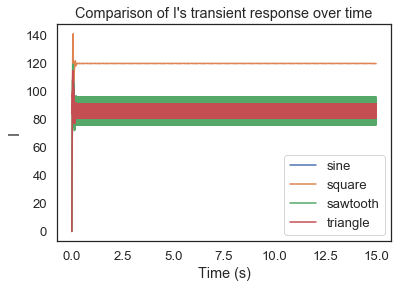

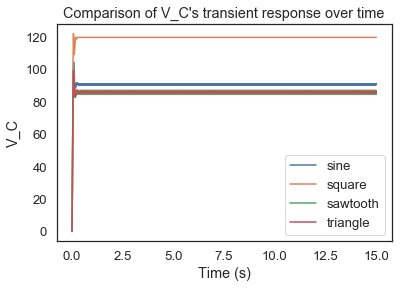

In [10]:
plot_results(responses_abstract)

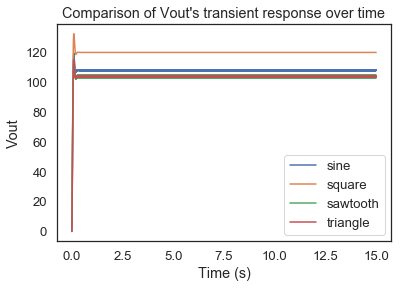

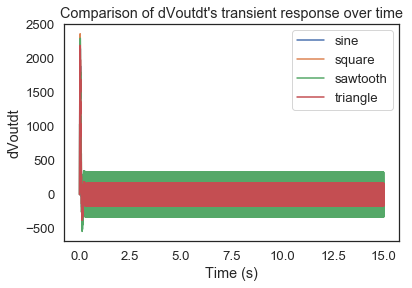

In [11]:
plot_results(responses_analytic)

# Validation against FMU Simulation

Initially, the attempt to validate our model was to use experimental data of from creating the rectifiers we are modeling. However, we assume in our model that the diodes are ideal, and the diodes on hand for experiment were far from that assumption. We therefore chose to utilize a commercial-grade modeling tool to create a rectifier model, and compare our results against its output.

The language used by the modeling tool is Modelica. This is a non-proprietary domain-specific modeling language meant for modeling the dynamic behavior of systems via an object-oriented component approach. Models are described via discrete, algebraic, and/or differential equations; Modelica abstracts out the process of mathematically solving the system by describing systems by a set of states and flows, with connections describing actual physical coupling (ex. connection of two wire bodies allowing the flow of heat). The solving is handled by the tool, thus allowing the user to conveniently avoid explicitly solving for the causal relationships between states, and focus only on the model at hand.

The modeling process in Modelica was done in two steps - the actual model construction, and the simulation and gathering of data. The model was constructed using the open-source tool OpenModelica, made by the OpenModelica Consortium. The simulation and gathering was done by exporting the model into an FMU. FMU's are compressed versions of models that follow the FMI Standard, allowing them to be used across different modeling tools and modeling langagues. Post creation of the FMU, the JModelica tool, made by the company Modelon, was used to manipulate, simulate, and gather results from it.

The specifics related to the Modelica and FMU modeling is listed in Appendix C.

The data from the FMU simulations is then loaded and compared against the results of our Python model.

In [12]:
fmu_sine_Vout = pd.read_csv('FMUSimSineWaveData_Vout.csv')
fmu_sine_Vout = pd.Series(np.array(fmu_sine_Vout['0.0.1'].values, dtype=float), 
                          index=np.array(fmu_sine_Vout['0.0'].values, dtype=float))

fmu_square_Vout = pd.read_csv('FMUSimSquareWaveData_Vout.csv')
fmu_square_Vout = pd.Series(np.array(fmu_square_Vout['0.0.1'].values, dtype=float), 
                            index=np.array(fmu_square_Vout['0.0'].values, dtype=float))

fmu_sawtooth_Vout = pd.read_csv('FMUSimSawtoothWaveData_Vout.csv')
fmu_sawtooth_Vout = pd.Series(np.array(fmu_sawtooth_Vout['0.0.1'].values, dtype=float), 
                              index=np.array(fmu_sawtooth_Vout['0.0'].values, dtype=float))

fmu_triangle_Vout = pd.read_csv('FMUSimTriangleWaveData_Vout.csv')
fmu_triangle_Vout = pd.Series(np.array(fmu_triangle_Vout['0.0.1'].values, dtype=float), 
                              index=np.array(fmu_triangle_Vout['0.0'].values, dtype=float))

None

Text(0.5,1,'Comparison of both Simulation Responses vs. Modelica FMU Response - Triangle Wave')

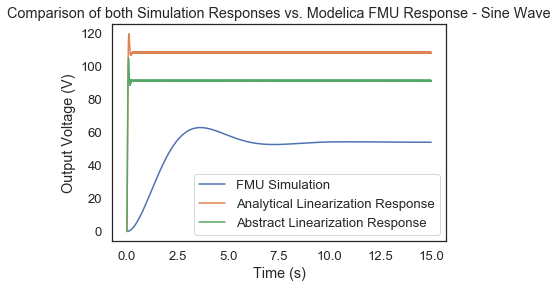

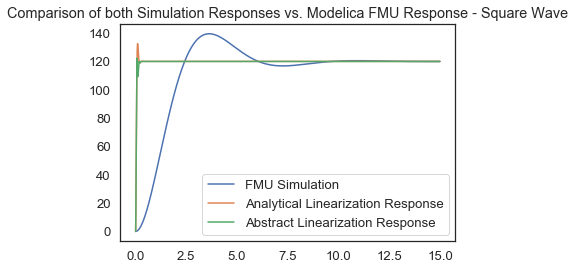

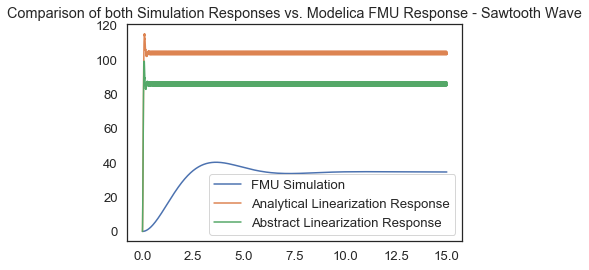

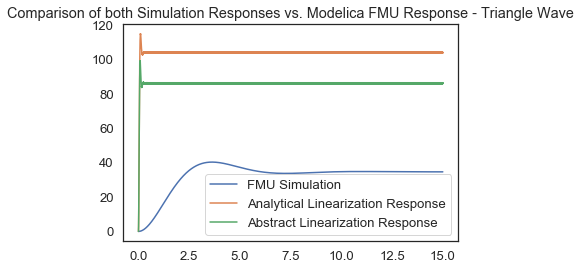

In [13]:
plt.figure(3)
fmu_sine_Vout.plot()
responses_analytic['results']['sine']['Vout'].plot()
responses_abstract['results']['sine']['V_C'].plot()
plt.xlabel('Time (s)')
plt.ylabel('Output Voltage (V)')
plt.legend(['FMU Simulation', 'Analytical Linearization Response', 'Abstract Linearization Response'])
plt.title('Comparison of both Simulation Responses vs. Modelica FMU Response - Sine Wave')

plt.figure(4)
fmu_square_Vout.plot()
responses_analytic['results']['square']['Vout'].plot()
responses_abstract['results']['square']['V_C'].plot()
plt.legend(['FMU Simulation', 'Analytical Linearization Response', 'Abstract Linearization Response'])
plt.title('Comparison of both Simulation Responses vs. Modelica FMU Response - Square Wave')

plt.figure(5)
fmu_sawtooth_Vout.plot()
responses_analytic['results']['sawtooth']['Vout'].plot()
responses_abstract['results']['sawtooth']['V_C'].plot()
plt.legend(['FMU Simulation', 'Analytical Linearization Response', 'Abstract Linearization Response'])
plt.title('Comparison of both Simulation Responses vs. Modelica FMU Response - Sawtooth Wave')

plt.figure(6)
fmu_triangle_Vout.plot()
responses_analytic['results']['triangle']['Vout'].plot()
responses_abstract['results']['triangle']['V_C'].plot()
plt.legend(['FMU Simulation', 'Analytical Linearization Response', 'Abstract Linearization Response'])
plt.title('Comparison of both Simulation Responses vs. Modelica FMU Response - Triangle Wave')

# Interpretation of our results

Overall, we observe that the time for the output voltage to reach steady state is independent of the input waveform; however, the magnitude of the output voltage is affected by the input waveform. This leads us to our overall conclusion:
- **For our given rectifier design, the transient response's duration is independent of input waveform, while the transient's response amplitude is affected by the input waveform.**

Looking at the characterstics of the simulation response depending on the linearization type, we notice that the abstract response and the analytical response share similar transient response profiles, while differing in magnitude and smoothness. In particular, we note that the abstract linearization's steady state output's magnitudes lie below 100V, while that of the analytical linearization's lie above 100V. The analytical linearization produces smooth output for all input waveforms, while the abstract linearization's response to the square wave input is very choppy (all other inputs were smooth in output).

In our validation, we notice that the FMU's response is largely different than that of our model. This could be due to various reasons, one potentially being that the solver used by the FMU is the nonlinear solver CVODE. We really are not sure what the reason for this discrepancy is, though, and this is a point for future investigation and improvement.